<a href="https://colab.research.google.com/github/victormurcia/CTS_Test/blob/main/CTS_Unifying_Routines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#I need to import locale to ensure that the encoding is set to UTF-8 (weird Google Colab bug)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

#Check the current build in Google Colab
!cat /etc/*release
print('\n')

#Check CUDA version
!nvcc --version
print('\n')

#Ensure that the required packages are installed in the current environment
install_pckgs = True
if install_pckgs == True:
  #General functionalities
  !pip install numpy --quiet
  !pip install pandas --quiet
  !pip install seaborn --quiet
  !pip install matplotlib --quiet
  !pip install "dask[complete]" --quiet
  !pip install ipywidgets --quiet

  #NLP Packages
  !pip install spacy==3.4.4 --quiet
  !pip install scispacy --quiet
  !pip install negspacy --quiet
  !pip install nltk

  #Medspacy Stuff (Including QuickUMLS Installation)
  !pip install medspacy --quiet
  !conda install -c conda-forge -q -y libiconv
  !pip install -q unidecode
  !pip install unqlite>=0.8.1
  !pip install medspacy_simstring>=2.1
  !pip install --no-deps medspacy_quickumls==2.6
  !pip install leveldb

  #Stuff for Transformer models
  !pip install transformers
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet 
  print('\n')

#Spacy models used for processing biomedical, scientific, or clinical text 
#Spacy pipeline for biomedical data.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data. Has a larger vocabulary and 50k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz --quiet
#This one is another spacy pipeline with 785k vocabulary and uses scibert-base as a transformer model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_scibert-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data with 600k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_lg-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the CRAFT corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_craft_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the JNLPBA corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_jnlpba_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BC5CDR corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BIONLP13CG corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz --quiet
#This is the med7 transformer model found here: https://github.com/kormilitzin/med7
!pip install https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl --quiet
#This is the med7 vector model 
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl --quiet

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=20.04
DISTRIB_CODENAME=focal
DISTRIB_DESCRIPTION="Ubuntu 20.04.5 LTS"
NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 30.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the f

In [2]:
#Import the required libraries/packages
#General utilities
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, time,sys, re,datetime,requests
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from tqdm import tqdm
import urllib.error
from ast import literal_eval
import ast

#NLP Stuff
#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #Load stopwords
from spacy.language import Language
from spacy.tokenizer import Tokenizer
#Scispacy
import scispacy
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector
from scispacy.hyponym_detector import HyponymDetector
#Medspacy
import medspacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent

from quickumls.constants import MEDSPACY_DEFAULT_SPAN_GROUP_NAME
import quickumls.spacy_component
from medspacy.util import get_quickumls_demo_dir
from medspacy.util import DEFAULT_PIPE_NAMES
from medspacy.visualization import visualize_ent
from medspacy.section_detection import Sectionizer

from negspacy.negation import Negex

#To use Transformers models from HuggingFace
import transformers
from transformers import AutoTokenizer, AutoModel,AutoModelForTokenClassification

#Enable data to be extracted from my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load Patient Dataframe
url = 'https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/100_veteran_df.csv'
patients_df = pd.read_csv(url)

#Load the inclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ic.csv'
parsed_ct_ic = pd.read_csv(url)

#Load the exclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ec.csv'
parsed_ct_ec = pd.read_csv(url)

In [12]:
patients_df.columns

Index(['Unnamed: 0', 'CODE_als', 'DESCRIPTION_als', 'Id_cps', 'CODE_cps',
       'DESCRIPTION_cps', 'REASONCODE_cps', 'REASONDESCRIPTION_cps',
       'CODE_cds', 'DESCRIPTION_cds', 'CODE_dvs', 'DESCRIPTION_dvs', 'UDI_dvs',
       'Id_iss', 'BODYSITE_CODE_iss', 'BODYSITE_DESCRIPTION_iss',
       'MODALITY_CODE_iss', 'MODALITY_DESCRIPTION_iss', 'SOP_CODE_iss',
       'SOP_DESCRIPTION_iss', 'CODE_ims', 'DESCRIPTION_ims', 'CODE_mds',
       'DESCRIPTION_mds', 'DISPENSES_mds', 'TOTALCOST_mds', 'REASONCODE_mds',
       'REASONDESCRIPTION_mds', 'CODE_obs', 'DESCRIPTION_obs', 'VALUE_obs',
       'UNITS_obs', 'Id_pts', 'BIRTHDATE_pts', 'PREFIX_pts', 'MARITAL_pts',
       'RACE_pts', 'ETHNICITY_pts', 'GENDER_pts', 'BIRTHPLACE_pts', 'CITY_pts',
       'STATE_pts', 'COUNTY_pts', 'ZIP_pts', 'LAT_pts', 'LON_pts',
       'HEALTHCARE_EXPENSES_pts', 'HEALTHCARE_COVERAGE_pts', 'CODE_prs',
       'DESCRIPTION_prs', 'REASONCODE_prs', 'REASONDESCRIPTION_prs',
       'CODE_sps', 'DESCRIPTION_sps'],
      dt

In [13]:
#Order of operations
# 1. Load the patients dataframe
# 2. Extract the EHR for the current patient
# 3. Preprocess each patient feature column
# 4. Run the NER model on each patient feature
# 5. Run a query on clinicaltrials.gov for all the conditions present in the patient profile
# 6. Extract the eligibility criteria for each queried clinical trial for each condition
# 7. Split eligibility criteria into inclusion/exclusion sections
# 8. Run NER model on both inclusion/exclusion sections
# 9. Determine Sorensen-Dice index between inclusion/exclusion sections and the patient EHR
# 10. Return the complete list of clinical trials stating whether the patient would qualify or not for each clinical trial

In [4]:
# define a function to convert age strings to years
def convert_age(age_str):
    if pd.isna(age_str):
        return None
    age_components = age_str.split()
    if len(age_components) == 2 and (age_components[1] == 'Years' or age_components[1] == 'Year'):
        return int(age_components[0])
    elif len(age_components) == 2 and (age_components[1] == 'Months' or age_components[1] == 'Month'):
        return int(age_str.split()[0])/12
    elif len(age_components) == 4 and age_components[3] == 'Months':
        return int(age_components)/12
    else:
        return None
########################################################################################################
def str_to_list(s):
  """
  Convert a string representation of a list to a Python list.

  Args:
  s (str): A string representation of a list.

  Returns:
  list: The list represented by the input string.

  Raises:
  SyntaxError: If the input string is not a valid Python list.
  """
  # Replace 'nan' with 'None' for compatibility with ast.literal_eval
  s = s.replace("nan", "None")
  return ast.literal_eval(s)

########################################################################################################
def list_to_string(lst,mode):
  """
  Convert a list to a string using the specified mode.

  Args:
  lst (list): A list to convert to a string.
  mode (int): The mode to use for converting the list to a string. Must be 1 or 2.

  Returns:
  str: The list converted to a string using the specified mode. If the mode is invalid,
        returns 0.

  Raises:
  ValueError: If the mode is not 1 or 2.
  """
  if mode == 1:
    return ' '.join([str(i) if i is not None else 'None' for i in lst])
  elif mode == 2:
    return ''.join([str(i) if i is not None else 'None' for i in lst])
  else:
    print('Invalid Mode')
    return 0

########################################################################################################
def expand_list_to_df(final_patient_df,list_of_aspects,prefs):
  """
  Convert a list of aspects and corresponding prefixes into a Pandas DataFrame.

    Args:
        list_of_aspects (list): A list of aspects for each patient.
        prefs (list): A list of prefixes for each condition to be used for naming.

    Returns:
        pandas.DataFrame: A DataFrame containing the aspects and corresponding conditions
            for all patients.
    """
  df_list = []
  for i in range(len(list_of_aspects)):
    c_aspect = list(set(final_patient_df['Patient_Profile'][i]))
    pref = prefs[i]
    n_aspects = len(c_aspect)
    aspect_count = [pref + str(i) for i,x in enumerate(c_aspect)]
    aspect_dict = zip(aspect_count,c_aspect)
    aspect_df = pd.DataFrame(aspect_dict,columns=['aspects', 'Patient_Profile'])
    df_list.append(aspect_df)
  
  #Create dataframe from list of dataframes
  result = pd.concat(df_list).reset_index(drop=True)

  return result
########################################################################################################
def create_patient_df_for_NER(patients_df):
  """
  This function creates a dataframe for a single patient from the 
  """
  #Select a single row from the DataFrame
  row_data = patients_df.loc[0]

  #Create a new DataFrame with the single row
  patient_df = pd.DataFrame([row_data], columns=row_data.index)

  #Select columns that summarize patient profile and put them into a list
  allergies     = patient_df['DESCRIPTION_als'].apply(str_to_list)
  condition     = patient_df['DESCRIPTION_cds'].apply(str_to_list)
  devices       = patient_df['DESCRIPTION_dvs'].apply(str_to_list)
  immunizations = patient_df['DESCRIPTION_ims'].apply(str_to_list)
  medications   = patient_df['DESCRIPTION_mds'].apply(str_to_list)
  procedures    = patient_df['DESCRIPTION_prs'].apply(str_to_list)
  birthday      = patient_df['BIRTHDATE_pts'].apply(str_to_list)
  marital       = patient_df['MARITAL_pts'].apply(str_to_list)
  race          = patient_df['RACE_pts'].apply(str_to_list)
  ethnicity     = patient_df['ETHNICITY_pts'].apply(str_to_list)
  gender        = patient_df['GENDER_pts'].apply(str_to_list)
  city          = patient_df['CITY_pts'].apply(str_to_list)
  county        = patient_df['COUNTY_pts'].apply(str_to_list)

  ######################################################################################################
  #The data from the observation.csv files contain simulated unstructured data and requires different handling than the other elements.
  #1. Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used.
  observations  = ast.literal_eval(patient_df['DESCRIPTION_obs'][0].replace("nan", "None"))
  values        = ast.literal_eval(patient_df['VALUE_obs'][0].replace("nan", "None"))
  units         = ast.literal_eval(patient_df['UNITS_obs'][0].replace("nan", "None"))

  #Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used to define the patient.
  result_dict = dict(zip(observations, zip(values, units)))
  temp_df = pd.DataFrame.from_dict(result_dict).fillna('')
  new_row = temp_df.apply(lambda x: ' '.join(x), axis=0)
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
  obs_df['aspects'] = temp_df.columns
  obs_df = obs_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index(drop=True)
  ######################################################################################################

  #Make list for patient profile
  patient_prof_list = [allergies, condition, devices, immunizations, medications, procedures, birthday, marital, race, ethnicity, gender, city, county]
  patient_prof_cols = ['allergies', 'condition', 'devices', 'immunizations', 'medications', 'procedures', 'birthday', 
                       'marital', 'race', 'ethnicity', 'gender', 'city', 'county']

  #Create a dictionary with column names and Series data
  data_dict = dict(zip(patient_prof_cols, patient_prof_list))

  #Create a new DataFrame with the single column
  patient_prof = pd.DataFrame(data_dict)

  #Concatenate the Series data into a single Series
  combined_series = pd.concat(patient_prof_list)

  #Create a DataFrame with a single column using the combined Series
  final_patient_df = pd.DataFrame({'Patient_Profile': combined_series})

  #Get column names of patient df
  final_patient_df['aspects'] = patient_prof_cols

  #Change the order of columns,reset the index, and drop the index column
  final_patient_df = final_patient_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index().drop('index',axis=1)

  #Concatenate the oberservation df and the rest of the patient profile
  final_patient_df = pd.concat([final_patient_df, obs_df]).reset_index(drop=True)
  
  #Expand the categories of patient aspects so that every reading is in its own row instead of having a list
  list_of_aspects = final_patient_df['Patient_Profile'][0:5]
  prefs = ['allergy_', 'condition_','device_','immunization_','meds_','procedures_']
  result = expand_list_to_df(final_patient_df,list_of_aspects,prefs)
  final_patient_profile_df = pd.concat([final_patient_df,result]).reset_index(drop=True)
  final_patient_profile_df = final_patient_profile_df.drop(final_patient_profile_df.index[0:6]).reset_index(drop=True)
  
  #Convert the list column to a string column separated by a single space
  final_patient_profile_df['Patient_Profile'][:7] = final_patient_profile_df['Patient_Profile'][:7].apply(list_to_string, args = (1,))#.apply(lambda x: ' '.join(map(str, eval(x))))

  #Create new column that combines the aspects and Patient_Profile columns into a single column to be parsed
  final_patient_profile_df['text_to_parse'] = final_patient_profile_df['aspects'] + ' is ' + final_patient_profile_df['Patient_Profile']

  return final_patient_profile_df
########################################################################################################
def get_umls_codes(text, model, suffix, semantic_type_map):
  """
  Extracts UMLS codes, labels, and semantic mappings from a given text using a pre-trained spaCy model.

  Args:
  - text: input text to extract UMLS codes and labels from
  - model: pre-trained spaCy model to use for NLP tasks
  - suffix: a string to append to the keys in the output dictionary
  - semantic_type_map: a dictionary mapping UMLS semantic types to human-readable labels

  Returns:
  - list of dictionaries containing UMLS code information, labels, and semantic mappings for each entity in the text
  """
  # Process the text and extract UMLS codes
  doc = model(text)
  umls_codes = []

  for entity in doc.ents:
    for umls_ent in entity._.kb_ents:
      umls_id = umls_ent[0]
      umls_entity = model.get_pipe("scispacy_linker").kb.cui_to_entity[umls_id]
      semantic_type = umls_entity.types[0]
      mapped_type = semantic_type_map.get(semantic_type, "Unknown")

      umls_codes.append({
        "text" + suffix: entity.text,
        "umls_id" + suffix: umls_id,
        "score" + suffix: umls_ent[1],
        "label" + suffix: entity.label_,
        "semantic_mapping" + suffix: mapped_type
      })

  return umls_codes
########################################################################################################
def extract_values(dicts, key):
  """
  Extract a list of values corresponding to the specified key from a list of dictionaries.

    Args:
        dicts (list): A list of dictionaries.
        key (str): The key to extract values for.

    Returns:
        list: A list of values corresponding to the specified key. If the key is not present in a
              dictionary, None is returned for that dictionary.
    """
  return [d.get(key, None) for d in dicts]
########################################################################################################
def run_ner(df,col_name,model,semantic_type_map):
  """
  Extracts UMLS codes from text data in a given DataFrame column using a pre-trained spaCy model.

  Args:
  - df: pandas DataFrame containing the text data
  - col_name: string representing the name of the column in df that contains the text data
  - model: pre-trained spaCy model to use for NLP tasks

  Returns:
  - pandas DataFrame with new columns for each UMLS code extracted from the text data
  """

  if col_name == 'text_to_parse':#'Patient_Profile':
    ner_results_col = 'umls_codes_patient'
    suffix = '_pat'
  elif col_name == 'inclusion_criteria':
    ner_results_col = 'umls_codes_ic'
    suffix = '_ic'
  elif col_name == 'exclusion_criteria':
    ner_results_col = 'umls_codes_ec'
    suffix = '_ec'
  else:
    print('Invalid column name')

  #Run the NER model on patient df and get UMLS codes after parsing and entity linking
  df[ner_results_col] = df[col_name].apply(get_umls_codes, args = (model,suffix,semantic_type_map))

  # Create new columns from the keys in the dictionaries within the 'info' column lists
  unique_keys = set().union(*(d.keys() for dicts in df[ner_results_col] for d in dicts))

  #Unpack the dictionary keys into separate columns
  for key in unique_keys:
    df[key] = df[ner_results_col].apply(lambda dicts: extract_values(dicts, key))

  return df
########################################################################################################
def contains_multiple_words(s):
  """
  Check if a string is composed of multiple space-separated words.

  Args:
  s (str): A string to check.

  Returns:
  bool: True if the input string contains multiple space-separated words, False otherwise.
  """
  if len(s.split()) > 1:
    return True
  else:
    return False
########################################################################################################
def filter_list(list1, list2, values):
  """
  Returns a new list made by only returning the elements of list1 based on the values of list2.

  Parameters:
  list1 (list): The list of elements to filter.
  list2 (list): The list of values used for filtering.
  values (list): A list of values to filter on.

  Returns:
  list: A new list that contains only the elements of list1 where list2 is equal to any of the values in the values list.
  """
  new_list = [list1[i] for i in range(len(list2)) if list2[i] in values]
  return new_list
########################################################################################################
def get_list_of_conditions_from_patient_df(patient_ner_df,semantic_type_map):
  """
  """
  #Make lists of conditions and their semantic counterparts from the parsed patient dataframe
  list2 = patient_ner_df['semantic_mapping_pat'].explode().tolist()
  list1 = patient_ner_df['text_pat'].explode().tolist()

  #Return list of conditions that have been labeled with one of the terms below

  #Get all the values as a list
  #labels =  list(semantic_type_map.values())#['Antibiotic','Clinical_Drug','Disease','Drug']
  semantic_type_map = {
    "T190": "Anatomical_Abnormality",
    "T195": "Antibiotic",
    "T007": "Bacterium",
    "T053": "Behavior",
    "T103": "Chemical",
    "T200": "Clinical_Drug",
    "T060": "Diagnostic_Procedure",
    "T047": "Disease",
    "T121": "Drug",
    "T126": "Enzyme",
    "T004": "Fungus",
    "T028": "Gene",
    "T131": "Hazardous_Substance",
    "T125": "Hormone",
    "T129": "Immunologic_Factor",
    "T197": "Inorganic_Chemical",
    "T037": "Injury",
    "T074": "Medical Device",
    "T048": "Mental_Dysfunction",
    "T109": "Organic_Chemical",
    "T001": "Organism",
    "T067": "Phenomenon",
    "T121": "Pharmacologic_Substance",
    "T167": "Substance",
    "T184": "Symptom",
    "T005": "Virus",
    "T127": "Vitamin"
    }
  labels =  list(semantic_type_map.values())#['Antibiotic','Clinical_Drug','Disease','Drug']
  #labels =  ['Antibiotic','Clinical_Drug','Disease','Drug']
  filtered_list = filter_list(list1, list2, labels)
  
  #Get list of conditions from parsed patient dataframe and remove duplicates
  list_of_conditions = list(set(filtered_list))

  # Remove nan values from the list using list comprehension and sort elements in alphabetical order
  list_of_conditions = sorted([x for x in list_of_conditions if not pd.isna(x)])

  # Define a regular expression pattern to match brackets and parentheses
  pattern = r"[\[\]\(\)]"

  # Remove brackets and parentheses from each element in the list
  list_of_conditions = [re.sub(pattern, "", str(elem)) for elem in list_of_conditions]

  return list_of_conditions
########################################################################################################
def get_clinical_trials(condition):
  """
  Creates a pandas dataframe from a query to clinicaltrials.gov

  Args:
  - condition: string representing the condition to search for

  Returns:
  - pandas dataframe with clinical trial data
  """
  #Check that condition is only 1 word else concatenate the string with a + sign
  multiword_condition = contains_multiple_words(condition)
  if multiword_condition == True:
    condition = "+".join(condition.split())
  #print(condition)
  a = 'https://clinicaltrials.gov/api/query/study_fields?expr='
  b = '&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CMinimumAge%2CMaximumAge%2CGender%2CStudyPopulation%2CEligibilityCriteria'
  c = '&min_rnk=1&max_rnk=1000&fmt=csv'
  q=(a + condition + b + c)
  #print(q)
  #qtrials_df = pd.read_csv(q,skiprows=10)
  # Read CSV data from URL and handle errors
  for i in range(5):
    try:
      qtrials_df = pd.read_csv(q, skiprows=10)
      break
    except urllib.error.URLError as e:
      print("URLError:", e.reason)
      print("Retrying in 5 seconds...")
      time.sleep(5)
    except urllib.error.HTTPError as e:
      if e.code == 500:
        print(condition,"HTTP Error 500: Internal Server Error")
      else:
        print("HTTP Error:", e.code)
      break
  else:
    raise ValueError("Unable to connect to the server after 5 attempts")
  return qtrials_df 
########################################################################################################
#PART 4. Query for clinical trials based on patient conditions
def query_trials_wrapper(list_of_conditions):
  """
  """
  list_of_cts = []
  for condition in list_of_conditions:
    #print(condition)
    qtrials_df = get_clinical_trials(condition)
    list_of_cts.append(qtrials_df)

  # Concatenate all DataFrames in the list into a single DataFrame
  all_trials_df = pd.concat(list_of_cts, ignore_index=True)

  return all_trials_df
########################################################################################################
def split_criteria(eligibility_criteria):
    # Split the input string
    substrings = eligibility_criteria.split('||')
    # Initialize the inclusion and exclusion criteria sections
    inclusion_criteria = ''
    exclusion_criteria = ''

    # Loop through the substrings to build the inclusion and exclusion criteria sections
    for i in range(len(substrings)):
        if 'Key Inclusion Criteria:' in substrings[i] or 'Inclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                inclusion_criteria += substrings[i+1]
        elif 'Key Exclusion Criteria:' in substrings[i] or 'Exclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                exclusion_criteria += substrings[i+1]

    # Return the inclusion and exclusion criteria sections as a tuple
    return pd.Series([inclusion_criteria, exclusion_criteria])
########################################################################################################
def calculate_SDI(patient_ner_df,parsed_trials_df):

  #Remove duplicates from the inclusion and exclusion criteria codes
  parsed_trials_df['umls_id_ic_clean'] = parsed_trials_df['umls_id_ic'].apply(lambda x: list(set(x)))
  parsed_trials_df['umls_id_ec_clean'] = parsed_trials_df['umls_id_ec'].apply(lambda x: list(set(x)))

  #Make list of patient umls codes, remove duplicates and remove NaNs
  patient_codes_list = sorted(list(set([x for x in patient_ner_df['umls_id_pat'].explode().tolist() if not pd.isna(x)])))

  # Compute Sorensen-Dice Index between the list of patient codes and the list of codes of the inclusion criteria for each clinical trial
  parsed_trials_df['SDI'] = parsed_trials_df['umls_id_ic_clean'].apply(lambda x: common_elements_and_sorensen_dice(patient_codes_list, x))

  return parsed_trials_df
########################################################################################################
def sorensen_dice_index(list1, list2) -> float:
    set1 = set(list1)
    set2 = set(list2)
    return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))
########################################################################################################
def common_elements_and_sorensen_dice(list1, list2):
  """
  This function finds the common elements between two lists and places these common elements into a new list.
  Then, the sorensen-dice index between this new list and list1 is calculated. 

  """
  # Find the common elements between the two lists
  common = list(set(list1).intersection(list2))

  # Calculate the Sorensen-Dice index
  dice_index = 2 * len(common) / (len(list1) + len(common))

  # Return the new list, its length, and the Sorensen-Dice index
  return dice_index
########################################################################################################
def cts_parser(patients_df,model):
  """
  This function parses the electronic health records for a patient extracted from the Synthetic Veteran Suicide Dataset and a set of 
  Clinical Trials queried using the clinicaltrials.gov API to determine how good of a match a patient is to a clinical trial.
  """
  #Start timer
  start_time = time.time()

  #PART 1. Create and prepare single patient dataframe for NER
  print('Step 1/9 : Creating dataframe for patient')
  final_patient_df = create_patient_df_for_NER(patients_df)
  
  #PART 2. Run the NER model on the patient EHR
  print('Step 2/9 : Run NER on patient data')

  # Define the semantic_type_map
  semantic_type_map = {
    "T116": "Protein",
    "T052": "Activity",
    "T100": "Age_Group",
    "T190": "Anatomical_Abnormality",
    "T017": "Anatomical_Structure",
    "T195": "Antibiotic",
    "T007": "Bacterium",
    "T031": "Body_Substance",
    "T053": "Behavior",
    "T029": "Body_Location",
    "T023": "Body_Part",
    "T103": "Chemical",
    "T200": "Clinical_Drug",
    "T060": "Diagnostic_Procedure",
    "T056": "Recreational_Activity",
    "T047": "Disease",
    "T121": "Drug",
    "T126": "Enzyme",
    "T099": "Family_Group",
    "T004": "Fungus",
    "T028": "Gene",
    "T096": "Group",
    "T131": "Hazardous_Substance",
    "T125": "Hormone",
    "T129": "Immunologic_Factor",
    "T197": "Inorganic_Chemical",
    "T037": "Injury",
    "T130": "Indicator",
    "T034": "Laboratory_Result",
    "T074": "Medical Device",
    "T048": "Mental_Dysfunction",
    "T109": "Organic_Chemical",
    "T001": "Organism",
    "T042": "Organ Function",
    "T067": "Phenomenon",
    "T121": "Pharmacologic_Substance",
    "T101": "Patient_Group",
    "T098": "Population_Group",
    "T081": "Quantitative_Concept",
    "T080": "Qualitative Concept",
    "T089": "Regulation",
    "T167": "Substance",
    "T054": "Social_Behavior",
    "T184": "Symptom",
    "T079": "Temporal Concept",
    "T005": "Virus",
    "T127": "Vitamin"
    }
  patient_ner_df = run_ner(final_patient_df, 'text_to_parse', model, semantic_type_map)

  #PART 3. Get list of patient conditions after parsing EHR while also removing duplicates
  print('Step 3/9 : Creating list of patient conditions ')
  list_of_conditions = get_list_of_conditions_from_patient_df(patient_ner_df,semantic_type_map)
  print('Found ', len(list_of_conditions),' unique conditions on patient EHR')
  print(list_of_conditions)

  #PART 4. Query for clinical trials based on patient conditions and generate CT dataframe
  print('Step 4/9 : Querying for clinical trials')
  all_trials_df = query_trials_wrapper(list_of_conditions)

  #PART 5. Filter dataframe containing only clinical trials that are actively recruiting, match the patient gender and age prior to parsing
  print('Step 5/9 : Only include clinical trials that are actively recruiting')
  #Specify the gender of the patient
  patient_gender = patient_ner_df.loc[patient_ner_df['aspects'] == 'gender', 'Patient_Profile'].values[0]
  if patient_gender == 'M':
    patient_gender = 'Male'
  elif patient_gender == 'F':
    patient_gender = 'Female'

  #Determine patient age
  patient_bday = patient_ner_df.loc[patient_ner_df['aspects'] == 'birthday', 'Patient_Profile'].values[0]
  birth_date = datetime.datetime.strptime(patient_bday, '%Y-%m-%d').date()
  today = datetime.date.today()
  patient_age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))

  #Filter by Recruiting status
  recruiting_trials_df = all_trials_df[all_trials_df['OverallStatus']=='Recruiting'].reset_index()

  #Filter by gender inclusivity
  gender_mask = (recruiting_trials_df['Gender'] == patient_gender) | (recruiting_trials_df['Gender'] == 'All') 
  recruiting_trials_df = recruiting_trials_df[gender_mask].reset_index()

  # apply the function to the 'age' column
  recruiting_trials_df['MinimumAge'] = recruiting_trials_df['MinimumAge'].apply(convert_age)
  recruiting_trials_df['MaximumAge'] = recruiting_trials_df['MaximumAge'].apply(convert_age)

  # apply boolean indexing to select clinical trials whose minimum and maximum age encompass the patient age
  recruiting_trials_df = recruiting_trials_df[(recruiting_trials_df['MinimumAge'] <= patient_age) & (recruiting_trials_df['MaximumAge'] >= patient_age)]

  #PART 6. Create inclusion and inclusion criteria columns on dataframe for subsequent parsing
  print('Step 6/9 : Split eligibility criteria into inclusion and exclusion sections')
  recruiting_trials_df[['inclusion_criteria', 'exclusion_criteria']] = recruiting_trials_df['EligibilityCriteria'].astype(str).apply(split_criteria)
  nTrials = recruiting_trials_df.shape[0]
  print('Found ', nTrials, ' for current patient')
  #PART 7-8. Run the NER model on the eligibility criteria from the clinical trial df
  print('Step 7/9 : Run NER on Clinical Trial Inclusion Criteria')
  parsed_trials_df = run_ner(recruiting_trials_df,'inclusion_criteria',model,semantic_type_map)
  print('Step 8/9 : Run NER on Clinical Trial Exclusion Criteria')
  parsed_trials_df = run_ner(parsed_trials_df,'exclusion_criteria',model,semantic_type_map)

  #PART 9. Determine whether parsed patient profile has any criteria that is present on the exclusion criteria list
  print('Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes')
  final_df = calculate_SDI(patient_ner_df,parsed_trials_df)

  #End timer
  print("Parsing patient records took: %.2f seconds" % (time.time() - start_time))

  return final_patient_df,patient_ner_df,recruiting_trials_df,final_df

In [5]:
#List of available models
models = ["en_core_sci_sm","en_core_sci_md","en_core_sci_lg","en_core_sci_scibert","en_ner_craft_md","en_ner_jnlpba_md","en_ner_bionlp13cg_md","en_ner_bc5cdr_md","en_core_med7_lg"]

#Load the pre-trained spaCy NER model with sci-spaCy
model = spacy.load(models[2])

#Add the Negation pipe to spacy pipeline
if 'negex' not in model.pipe_names:
  model.add_pipe("negex")

#Add the abbreviation pipe to the spacy pipeline.
if 'abbreviation_detector' not in model.pipe_names:
  model.add_pipe("abbreviation_detector")
  
#Add the EntityLinker pipe to spacy pipeline
if 'scispacy_linker' not in model.pipe_names:
  model.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 1})
#quickumls_file_path = get_quickumls_demo_dir()
#print('quickumls_file_path:')
#print(quickumls_file_path)

#if 'medspacy_quickumls' not in model.pipe_names: 
#    model.add_pipe("medspacy_quickumls", config={"threshold": 0.7,
#                                           "result_type": "group",
#                                           # do not constrain to the best match for overlapping
#                                           "best_match": False,
#                                           "quickumls_fp": quickumls_file_path})
#    
print(model.pipe_names)

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmpg6olw3ou
Finished download, copying /tmp/tmpg6olw3ou to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmpfinw8gmf
Finished download, copying /tmp/tmpfinw8gmf to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmp85flmckf
Finished download, copying /tmp/tmp85flmckf to cache at /root/.scispacy/da

In [6]:
context = model.get_pipe("medspacy_context")

for rule in context.rules[:10]:
    print()
    print(rule)


ConTextRule(literal='absence of', category='NEGATED_EXISTENCE', pattern=None, direction='FORWARD')

ConTextRule(literal='adequate to rule out', category='NEGATED_EXISTENCE', pattern=[{'LOWER': {'IN': ['adequate', 'sufficient']}}, {'LOWER': 'to'}, {'LOWER': 'rule'}, {'LOWER': {'IN': ['him', 'her', 'them', 'patient', 'pt']}, 'OP': '?'}, {'LOWER': 'out'}, {'LOWER': {'IN': ['against', 'for']}, 'OP': '?'}], direction='FORWARD')

ConTextRule(literal='adequate to rule the patient out', category='NEGATED_EXISTENCE', pattern=[{'LOWER': {'IN': ['adequate', 'sufficient']}}, {'LOWER': 'to'}, {'LOWER': 'rule'}, {'LOWER': 'the'}, {'LOWER': {'IN': ['patient', 'pt']}}, {'LOWER': 'out'}, {'LOWER': {'IN': ['against', 'for']}, 'OP': '?'}], direction='FORWARD')

ConTextRule(literal='any other', category='NEGATED_EXISTENCE', pattern=None, direction='FORWARD')

ConTextRule(literal='apart from', category='NEGATED_EXISTENCE', pattern=[{'LOWER': 'apart'}, {'LOWER': {'IN': ['for', 'from']}}], direction='TERMIN

In [6]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
final_patient_df,patient_ner_df,recruiting_trials_df,final_df = cts_parser(patients_df,model)
patient_ner_df

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data
Step 3/9 : Creating list of patient conditions 
Found  48  unique conditions on patient EHR
['Acetaminophen', 'Acute viral pharyngitis', 'Ag', 'Amoxicillin', 'BMI', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Cat dander IgE Ab', 'Cholesterol', 'Chronic sinusitis', 'Cladosporium herbarum', 'Clavulanate', 'Concussion', 'Doxycycline Monohydrate', 'Fatigue', 'Fever', 'Fracture subluxation', 'Headache', 'Hemoglobin', 'Hep', 'Hep B', 'Hib', 'Hydrochloride 25 MG', 'IPV', 'Influenza virus A', 'Influenza virus B', 'Laceration', 'MCH', 'Naproxen sodium', 'Nausea', 'Otitis media', 'Pain', 'Penicillin V', 'Potassium', 'Sinusitis', 'Streptococcal sore throat', 'Tobacco smoking', 'Triglycerides', 'Viral sinusitis', 'Vomiting symptom', 'Whiplash injury', 'allergic rhinitis', 'diphenhydrAMINE', 'disorder', 'finding', 'mould', 'obesity']
Step 4/9 : Querying for clinical trials
Step 5/9 : Only include clinical trials tha

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,umls_id_pat,semantic_mapping_pat,score_pat,text_pat,label_pat
0,birthday,1975-03-24,birthday is 1975-03-24,[],[],[],[],[],[]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[C0024841],[Unknown],[1.0],[marital],[ENTITY]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C1315098...","[C1315098, C0007457]","[Unknown, Population_Group]","[0.9999998807907104, 1.0]","[race, white]","[ENTITY, ENTITY]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[C0015031],[Population_Group],[0.9999998807907104],[ethnicity],[ENTITY]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...","[C0079399, C0025646]","[Unknown, Protein]","[1.0, 1.0]","[gender, M]","[ENTITY, ENTITY]"
...,...,...,...,...,...,...,...,...,...
90,meds_2,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,meds_2 is Amoxicillin 250 MG / Clavulanate 125...,"[{'text_pat': 'Amoxicillin', 'umls_id_pat': 'C...","[C0002645, C0024467, C0110038, C0024467, C0993...","[Organic_Chemical, Unknown, Organic_Chemical, ...","[1.0, 1.0, 1.0, 1.0, 0.9999999403953552]","[Amoxicillin, MG, Clavulanate, MG, Oral Tablet]","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]"
91,meds_3,Acetaminophen 325 MG Oral Tablet,meds_3 is Acetaminophen 325 MG Oral Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[C0000970, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[1.0, 1.0, 0.9999999403953552]","[Acetaminophen, MG, Oral Tablet]","[ENTITY, ENTITY, ENTITY]"
92,meds_4,Acetaminophen 160 MG Chewable Tablet,meds_4 is Acetaminophen 160 MG Chewable Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[C0000970, C0024467, C0304290]","[Organic_Chemical, Unknown, Unknown]","[1.0, 1.0, 1.0]","[Acetaminophen, MG, Chewable Tablet]","[ENTITY, ENTITY, ENTITY]"
93,meds_5,diphenhydrAMINE Hydrochloride 25 MG Oral Tablet,meds_5 is diphenhydrAMINE Hydrochloride 25 MG ...,"[{'text_pat': 'diphenhydrAMINE', 'umls_id_pat'...","[C0012522, C1512523, C0993159]","[Organic_Chemical, Pharmacologic_Substance, Un...","[1.0, 0.8295060992240906, 0.9999999403953552]","[diphenhydrAMINE, Hydrochloride 25 MG, Oral Ta...","[ENTITY, ENTITY, ENTITY]"


In [7]:
final_patient_df

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,umls_id_pat,semantic_mapping_pat,score_pat,text_pat,label_pat
0,birthday,1975-03-24,birthday is 1975-03-24,[],[],[],[],[],[]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[C0024841],[Unknown],[1.0],[marital],[ENTITY]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C1315098...","[C1315098, C0007457]","[Unknown, Population_Group]","[0.9999998807907104, 1.0]","[race, white]","[ENTITY, ENTITY]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[C0015031],[Population_Group],[0.9999998807907104],[ethnicity],[ENTITY]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...","[C0079399, C0025646]","[Unknown, Protein]","[1.0, 1.0]","[gender, M]","[ENTITY, ENTITY]"
...,...,...,...,...,...,...,...,...,...
90,meds_2,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,meds_2 is Amoxicillin 250 MG / Clavulanate 125...,"[{'text_pat': 'Amoxicillin', 'umls_id_pat': 'C...","[C0002645, C0024467, C0110038, C0024467, C0993...","[Organic_Chemical, Unknown, Organic_Chemical, ...","[1.0, 1.0, 1.0, 1.0, 0.9999999403953552]","[Amoxicillin, MG, Clavulanate, MG, Oral Tablet]","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]"
91,meds_3,Acetaminophen 325 MG Oral Tablet,meds_3 is Acetaminophen 325 MG Oral Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[C0000970, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[1.0, 1.0, 0.9999999403953552]","[Acetaminophen, MG, Oral Tablet]","[ENTITY, ENTITY, ENTITY]"
92,meds_4,Acetaminophen 160 MG Chewable Tablet,meds_4 is Acetaminophen 160 MG Chewable Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[C0000970, C0024467, C0304290]","[Organic_Chemical, Unknown, Unknown]","[1.0, 1.0, 1.0]","[Acetaminophen, MG, Chewable Tablet]","[ENTITY, ENTITY, ENTITY]"
93,meds_5,diphenhydrAMINE Hydrochloride 25 MG Oral Tablet,meds_5 is diphenhydrAMINE Hydrochloride 25 MG ...,"[{'text_pat': 'diphenhydrAMINE', 'umls_id_pat'...","[C0012522, C1512523, C0993159]","[Organic_Chemical, Pharmacologic_Substance, Un...","[1.0, 0.8295060992240906, 0.9999999403953552]","[diphenhydrAMINE, Hydrochloride 25 MG, Oral Ta...","[ENTITY, ENTITY, ENTITY]"


In [8]:
recruiting_trials_df

,level_0,index,Rank,NCTId,BriefTitle,...,text_ec,umls_id_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
5,5,76,77,NCT03451487,"A Randomized, Single-blind, Parallel Group and...",...,"[History, presence, alcohol abuse, consumption...","[C0019664, C0392148, C0085762, C0009830, C5438...","[C0439234, C3898900, C0080105, C0421272, C0005...","[C0009237, C0439227, C0025663, C0000970, C0021...",0.029630
7,7,126,127,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,...,"[Age, years, older, years, Pre-operative pregn...","[C0001779, C0439234, C0001795, C0439234, C0032...","[C0411257, C0439234, C3850136, C4050142, C0000...","[C0439234, C0242402, C0001795, C0001779, C0032...",0.014925
8,8,134,135,NCT04882202,Acetaminophen and AKI After Aortic Surgery,...,"[patients, chronic kidney disease, dialysis, e...","[C0030705, C1561643, C0011945, C0034802, C0000...","[C0030705, C0205081, C0877130, C0020672]","[C0034802, C0000970, C0030705, C0084186, C0011...",0.000000
10,11,174,175,NCT05563961,"A Partial Randomized, Single-blind or Open-lab...",...,"[History, presence, alcohol abuse, consumption...","[C0019664, C0392148, C0085762, C0009830, C5438...","[C0439234, C3898900, C0001779, C0080105, C0001...","[C0009237, C0439227, C0025663, C0000970, C0021...",0.029630
12,13,201,202,NCT05626010,Efficacy of Acetaminophen-ibuprofen Combinatio...,...,"[refusal, study|emergency, renal, chronic pain...","[C0080100, C0013956, C0022646, C0150055, C0033...","[C2346733, C0030705]","[C0080100, C0151864, C0522473, C0022646, C0150...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3420,3732,31573,914,NCT05631535,Obesity Treatment With a Very Low Energy Diet ...,...,"[participant, weight loss program.|Weight loss...","[C0679646, C1262477, C0011860, C0020538, C0013...","[C0439234, C0008848, C0439228, C0684224, C0470...","[C1280500, C0016977, C3242151, C0679646, C0005...",0.044118
3421,3733,31577,918,NCT04643899,Effects of Electrostimulation on Glycemic Cont...,...,"[patients, guardianship, legal, patients|patie...","[C0030705, C0870627, C1301860, C0030705, C0021...","[C0439234, C0028756, C0205082, C1511481, C5236...","[C0023216, C0018246, C0013812, C0021102, C0030...",0.014925
3422,3734,31583,924,NCT04838678,Sympathetic Transduction in Obesity-associated...,...,"[groups, presence, cardiovascular disease, ren...","[C0441833, C0392148, C0007222, C0022658, C0262...","[C0009932, C0150369, C0001779, C0011900, C0020...","[C0037369, C0262926, C0022658, C0011847, C0441...",0.014925
3423,3735,31585,926,NCT03854058,Respiratory Muscle Strength in Patients With O...,...,"[disease, ventilatory, insufficiency|pacemaker...","[C0012634, C0087153, C0205412, C0180307, C0025...","[C0031880, C0205250, C1511481, C0520679, C0030...","[C0030706, C2350432, C1511481, C0149518, C0205...",0.014925


In [9]:
pd.set_option("display.max_columns", 15)
recruiting_trials_df.iloc[:, : 12]

,level_0,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,MinimumAge,MaximumAge,Gender,StudyPopulation,EligibilityCriteria
5,5,76,77,NCT03451487,"A Randomized, Single-blind, Parallel Group and...",Acetaminophen Toxicity,Recruiting,20.0,50.0,All,NaN,Inclusion Criteria:||Normal healthy adult subj...
7,7,126,127,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,Nephrectomy,Recruiting,18.0,89.0,All,NaN,Inclusion Criteria:||Be at least 18 years old|...
8,8,134,135,NCT04882202,Acetaminophen and AKI After Aortic Surgery,Aortic Surgery,Recruiting,20.0,100.0,All,NaN,Inclusion Criteria:||1) Patients undergoing ao...
10,11,174,175,NCT05563961,"A Partial Randomized, Single-blind or Open-lab...",Hepatitis|Pharmacology,Recruiting,20.0,50.0,All,NaN,Inclusion Criteria:||Normal healthy adult subj...
12,13,201,202,NCT05626010,Efficacy of Acetaminophen-ibuprofen Combinatio...,Thyroid Disease,Recruiting,20.0,65.0,All,NaN,Inclusion Criteria:||the patients undergoing s...
...,...,...,...,...,...,...,...,...,...,...,...,...
3420,3732,31573,914,NCT05631535,Obesity Treatment With a Very Low Energy Diet ...,Obesity|Weight Loss,Recruiting,18.0,55.0,All,NaN,Inclusion Criteria:||Adults (≥18 and ≤55 years...
3421,3733,31577,918,NCT04643899,Effects of Electrostimulation on Glycemic Cont...,Obesity Adult Onset,Recruiting,18.0,70.0,All,NaN,Inclusion Criteria:||men and women over 18 yea...
3422,3734,31583,924,NCT04838678,Sympathetic Transduction in Obesity-associated...,Hypertension|Obesity,Recruiting,18.0,55.0,All,NaN,"Inclusion Criteria:||Control - BMI<30, age 18-..."
3423,3735,31585,926,NCT03854058,Respiratory Muscle Strength in Patients With O...,Obesity Hypoventilation Syndrome,Recruiting,18.0,80.0,All,Patients with OHS or OHS-risk,Inclusion Criteria:||patients with BMI > 30 an...


In [10]:
final_df

,level_0,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,...,semantic_mapping_ec,label_ec,text_ec,umls_id_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
5,5,76,77,NCT03451487,"A Randomized, Single-blind, Parallel Group and...",Acetaminophen Toxicity,Recruiting,...,"[Unknown, Unknown, Mental_Dysfunction, Activit...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[History, presence, alcohol abuse, consumption...","[C0019664, C0392148, C0085762, C0009830, C5438...","[C0439234, C3898900, C0080105, C0421272, C0005...","[C0009237, C0439227, C0025663, C0000970, C0021...",0.029630
7,7,126,127,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,Nephrectomy,Recruiting,...,"[Unknown, Temporal Concept, Age_Group, Tempora...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Age, years, older, years, Pre-operative pregn...","[C0001779, C0439234, C0001795, C0439234, C0032...","[C0411257, C0439234, C3850136, C4050142, C0000...","[C0439234, C0242402, C0001795, C0001779, C0032...",0.014925
8,8,134,135,NCT04882202,Acetaminophen and AKI After Aortic Surgery,Aortic Surgery,Recruiting,...,"[Patient_Group, Disease, Unknown, Protein, Org...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[patients, chronic kidney disease, dialysis, e...","[C0030705, C1561643, C0011945, C0034802, C0000...","[C0030705, C0205081, C0877130, C0020672]","[C0034802, C0000970, C0030705, C0084186, C0011...",0.000000
10,11,174,175,NCT05563961,"A Partial Randomized, Single-blind or Open-lab...",Hepatitis|Pharmacology,Recruiting,...,"[Unknown, Unknown, Mental_Dysfunction, Activit...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[History, presence, alcohol abuse, consumption...","[C0019664, C0392148, C0085762, C0009830, C5438...","[C0439234, C3898900, C0001779, C0080105, C0001...","[C0009237, C0439227, C0025663, C0000970, C0021...",0.029630
12,13,201,202,NCT05626010,Efficacy of Acetaminophen-ibuprofen Combinatio...,Thyroid Disease,Recruiting,...,"[Unknown, Phenomenon, Body_Part, Symptom, Unkn...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[refusal, study|emergency, renal, chronic pain...","[C0080100, C0013956, C0022646, C0150055, C0033...","[C2346733, C0030705]","[C0080100, C0151864, C0522473, C0022646, C0150...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,3732,31573,914,NCT05631535,Obesity Treatment With a Very Low Energy Diet ...,Obesity|Weight Loss,Recruiting,...,"[Population_Group, Unknown, Disease, Disease, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[participant, weight loss program.|Weight loss...","[C0679646, C1262477, C0011860, C0020538, C0013...","[C0439234, C0008848, C0439228, C0684224, C0470...","[C1280500, C0016977, C3242151, C0679646, C0005...",0.044118
3421,3733,31577,918,NCT04643899,Effects of Electrostimulation on Glycemic Cont...,Obesity Adult Onset,Recruiting,...,"[Patient_Group, Unknown, Unknown, Patient_Grou...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[patients, guardianship, legal, patients|patie...","[C0030705, C0870627, C1301860, C0030705, C0021...","[C0439234, C0028756, C0205082, C1511481, C5236...","[C0023216, C0018246, C0013812, C0021102, C0030...",0.014925
3422,3734,31583,924,NCT04838678,Sympathetic Transduction in Obesity-associated...,Hypertension|Obesity,Recruiting,...,"[Unknown, Unknown, Disease, Disease, Unknown, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[groups, presence, cardiovascular disease, ren...","[C0441833, C0392148, C0007222, C0022658, C0262...","[C0009932, C0150369, C0001779, C0011900, C0020...","[C0037369, C0262926, C0022658, C0011847, C0441...",0.014925
3423,3735,31585,926,NCT03854058,Respiratory Muscle Strength in Patients With O...,Obesity Hypoventilation Syndrome,Recruiting,...,"[Disease, Medical Device, Qualitative Concept,...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[disease, ventilatory, insufficiency|pacemaker...","[C0012634, C0087153, C0205412, C0180307, C0025...","[C0031880, C0205250, C1511481, 

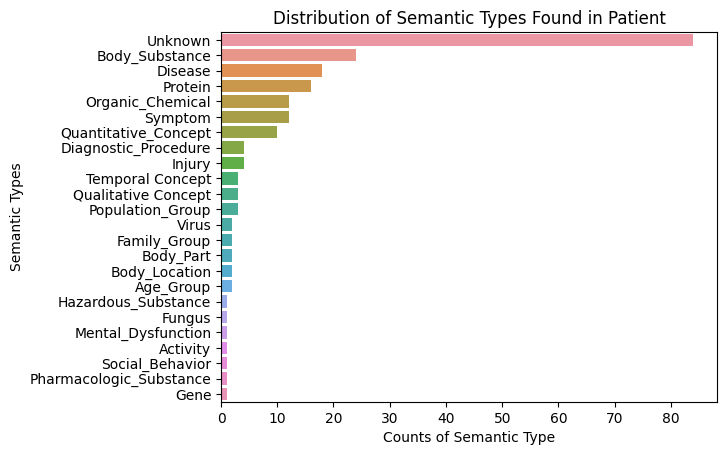

In [ ]:
sm_df = patient_ner_df.loc[:,['semantic_mapping_pat']]
exploded = sm_df.explode('semantic_mapping_pat').reset_index()
sns.countplot(y='semantic_mapping_pat', data=exploded,order=exploded['semantic_mapping_pat'].value_counts().index)
plt.xlabel('Counts of Semantic Type')
plt.ylabel('Semantic Types')
plt.title('Distribution of Semantic Types Found in Patient')
plt.show()

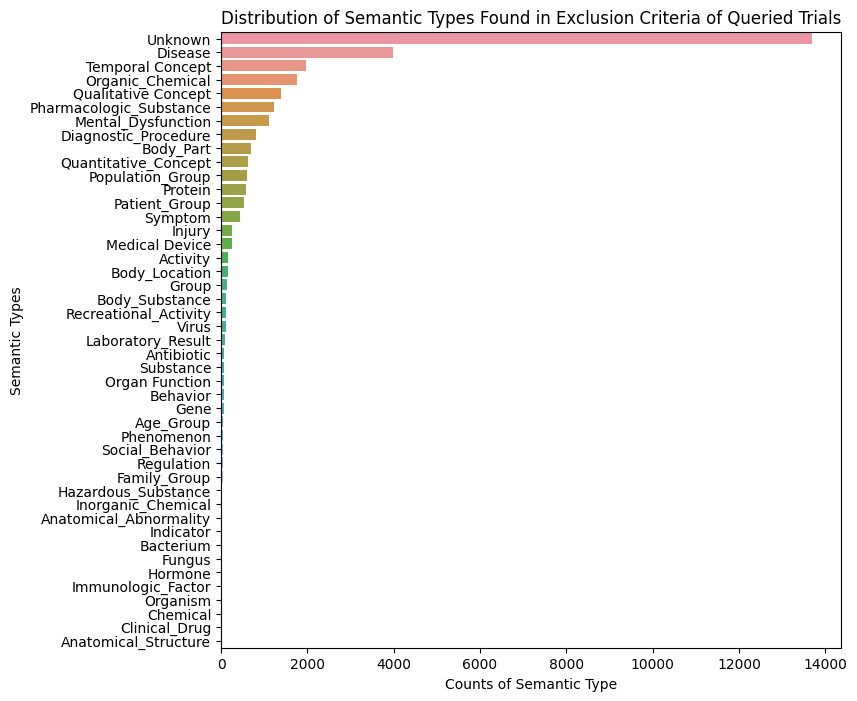

In [ ]:
smct_df = final_df.loc[:,['semantic_mapping_ec']]
exploded = smct_df.explode('semantic_mapping_ec').reset_index()
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(y='semantic_mapping_ec', data=exploded,order=exploded['semantic_mapping_ec'].value_counts().index)
plt.xlabel('Counts of Semantic Type')
plt.ylabel('Semantic Types')
plt.title('Distribution of Semantic Types Found in Exclusion Criteria of Queried Trials')
plt.show()

In [ ]:
exploded['semantic_mapping_ec'].value_counts()

Unknown                 13683
Disease                  3993
Temporal Concept         1965
Organic_Chemical         1750
Qualitative Concept      1379
                        ...  
Immunologic_Factor         10
Organism                    7
Chemical                    7
Clinical_Drug               2
Anatomical_Structure        1
Name: semantic_mapping_ec, Length: 45, dtype: int64

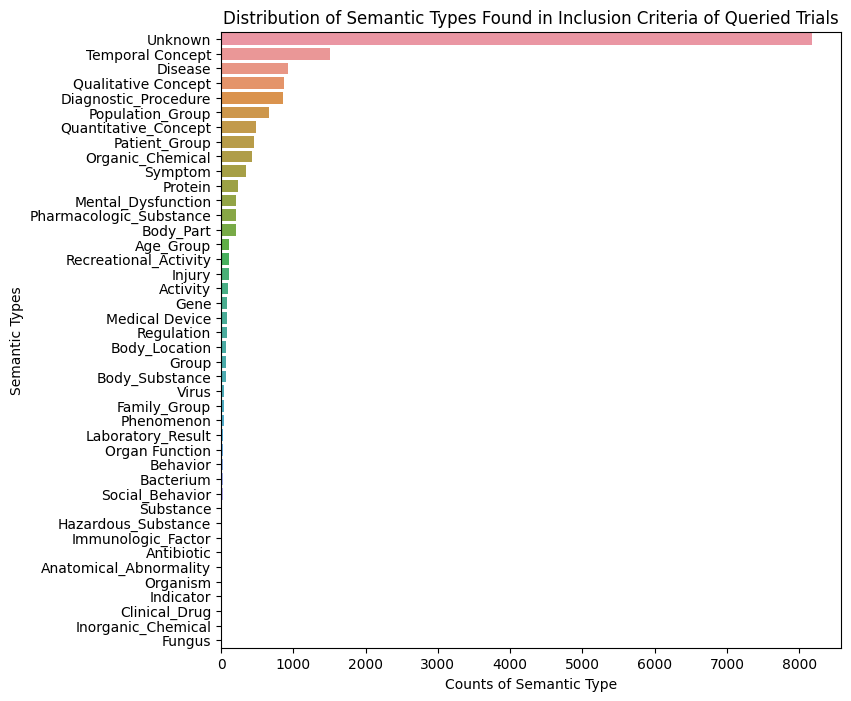

In [ ]:
smct_df = final_df.loc[:,['semantic_mapping_ic']]
exploded = smct_df.explode('semantic_mapping_ic').reset_index()
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(y='semantic_mapping_ic', data=exploded,order=exploded['semantic_mapping_ic'].value_counts().index)
plt.xlabel('Counts of Semantic Type')
plt.ylabel('Semantic Types')
plt.title('Distribution of Semantic Types Found in Inclusion Criteria of Queried Trials')
plt.show()

In [ ]:
final_df

,level_0,index,Rank,NCTId,BriefTitle,...,text_ec,semantic_mapping_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
5,5,77,78,NCT03451487,"A Randomized, Single-blind, Parallel Group and...",...,"[History, presence, alcohol abuse, consumption...","[Unknown, Unknown, Mental_Dysfunction, Activit...","[C0489786, C0086582, C0439234, C0421272, C0043...","[C0008972, C1527304, C0032134, C0002111, C0700...",0.031008
7,7,125,126,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,...,"[Age, older, Pre-operative pregnancy test, ele...","[Unknown, Age_Group, Diagnostic_Procedure, Unk...","[C2111393, C0030193, C0439824, C4683344, C0411...","[C0023884, C0001779, C0001795, C0032976, C0029...",0.000000
8,8,132,133,NCT04882202,Acetaminophen and AKI After Aortic Surgery,...,"[patients, chronic kidney disease, dialysis, e...","[Patient_Group, Disease, Unknown, Protein, Org...","[C0020672, C0030705, C0205081, C0877130]","[C0005437, C0034802, C0011945, C0000970, C0030...",0.000000
9,10,172,173,NCT05563961,"A Partial Randomized, Single-blind or Open-lab...",...,"[History, presence, alcohol abuse, consumption...","[Unknown, Unknown, Mental_Dysfunction, Activit...","[C0001779, C0439234, C0001675, C3898900, C0080...","[C0008972, C1527304, C0032134, C0002111, C0700...",0.031008
11,12,199,200,NCT05626010,Efficacy of Acetaminophen-ibuprofen Combinatio...,...,"[refusal, study|emergency, chronic pain, lacta...","[Unknown, Phenomenon, Symptom, Unknown, Qualit...","[C0030705, C2346733]","[C0008972, C0150055, C0522473, C0020517, C0013...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3132,3420,28888,911,NCT05631535,Obesity Treatment With a Very Low Energy Diet ...,...,"[participant, weight loss, hypertension, drugs...","[Population_Group, Unknown, Disease, Pharmacol...","[C2983605, C0439228, C0008972, C0679823, C0470...","[C0003289, C1280500, C0019993, C0004936, C0012...",0.046154
3133,3421,28892,915,NCT04643899,Effects of Electrostimulation on Glycemic Cont...,...,"[patients, guardianship, legal, protection|pre...","[Patient_Group, Unknown, Unknown, Unknown, Med...","[C0442711, C0005893, C0025266, C0439234, C0043...","[C3275055, C1301860, C0030163, C0205234, C0683...",0.015625
3134,3422,28898,921,NCT04838678,Sympathetic Transduction in Obesity-associated...,...,"[groups, presence, cardiovascular disease, ren...","[Unknown, Unknown, Disease, Disease, Unknown, ...","[C0242876, C0009932, C0003364, C0001779, C0011...","[C0011847, C0007222, C0441833, C0150312, C1519...",0.015625
3135,3423,28900,923,NCT03854058,Respiratory Muscle Strength in Patients With O...,...,"[disease, ventilatory, defibrillators, device,...","[Disease, Medical Device, Medical Device, Medi...","[C0005893, C0205250, C0030705, C1511481, C1516...","[C0180307, C0205486, C0030706, C0205125, C0221...",0.015625


In [ ]:
final_patient_df,patient_ner_df,recruiting_trials_df,final_df = cts_parser(patients_df,model)
patient_ner_df

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data
Step 3/9 : Creating list of patient conditions 
Found  71  unique conditions on patient EHR
['Ab', 'Acetaminophen', 'Acute viral pharyngitis', 'Ag', 'Amoxicillin', 'Arterial blood', 'BMI', 'Blood', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Cat dander', 'Chronic sinusitis', 'Cladosporium herbarum', 'Clavulanate', 'Concussion', 'Doxycycline', 'Entitic mass', 'Entitic volume', 'Fatigue', 'Fever', 'Fracture subluxation', 'Head', 'Headache', 'Hemoglobin', 'Hep A', 'Hep B', 'Hib', 'High Density Lipoprotein Cholesterol', 'IPV', 'IgE', 'IgE Ab', 'Influenza virus A', 'Influenza virus B Ag', 'Laceration', 'Latex', 'Low', 'MCV', 'Mass/volume', 'Naproxen sodium', 'Nasopharynx', 'Nausea', 'Otitis media', 'Pain severity', 'Penicillin V', 'Perennial allergic rhinitis', 'Score', 'Serum', 'Sinusitis', 'Streptococcal sore throat', 'Suspected', 'Tobacco smoking', 'Triglycerides', 'Viral sinusitis', 'Volume Fraction', 'V

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,label_pat,semantic_mapping_pat,text_pat,score_pat,umls_id_pat
0,birthday,1975-03-24,birthday is 1975-03-24,"[{'text_pat': 'birthday', 'umls_id_pat': 'C042...",[ENTITY],[Unknown],[birthday],[0.8192237615585327],[C0421451]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[ENTITY],[Unknown],[marital],[1.0],[C0024841]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C0034510...","[ENTITY, ENTITY]","[Population_Group, Population_Group]","[race, white]","[1.0, 1.0]","[C0034510, C0007457]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[ENTITY],[Population_Group],[ethnicity],[1.0],[C0015031]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...",[ENTITY],[Unknown],[gender],[1.0],[C0079399]
5,city,Chula Vista,city is Chula Vista,"[{'text_pat': 'city', 'umls_id_pat': 'C0008848...",[ENTITY],[Unknown],[city],[1.0],[C0008848]
6,county,San Diego County,county is San Diego County,"[{'text_pat': 'county', 'umls_id_pat': 'C00791...",[ENTITY],[Unknown],[county],[0.9999999403953552],[C0079170]
7,Body Height,182.3 cm,Body Height is 182.3 cm,"[{'text_pat': 'Body Height', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Body Height],[1.0],[C0005890]
8,Pain severity - 0-10 verbal numeric rating [Sc...,0.0 {score},Pain severity - 0-10 verbal numeric rating [Sc...,"[{'text_pat': 'Pain severity', 'umls_id_pat': ...","[ENTITY, ENTITY, ENTITY]","[Qualitative Concept, Quantitative_Concept, Un...","[Pain severity, Score, Reported]","[0.9999998807907104, 1.0, 1.0]","[C1507013, C0449820, C0684224]"
9,Body Weight,100.5 kg,Body Weight is 100.5 kg,"[{'text_pat': 'Body Weight', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Body Weight],[1.0],[C0005910]


In [8]:
final_df['SDI'].max()

0.1

In [ ]:
patient_gender = patient_ner_df.loc[patient_ner_df['aspects'] == 'gender', 'Patient_Profile'].values[0]
patient_age

'M'

In [ ]:
patient_bday = patient_ner_df.loc[patient_ner_df['aspects'] == 'birthday', 'Patient_Profile'].values[0]
birth_date = datetime.datetime.strptime(patient_bday, '%Y-%m-%d').date()
today = datetime.date.today()
patient_age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
patient_age

48

In [ ]:
pd.set_option("display.max_columns", 25)
final_df

,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,EligibilityCriteria,inclusion_criteria,exclusion_criteria,umls_codes_ic,label_ic,text_ic,umls_id_ic,score_ic,semantic_mapping_ic,umls_codes_ec,score_ec,semantic_mapping_ec,label_ec,text_ec,umls_id_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
0,3,4,NCT05617755,"AB-1015, an Integrated Circuit T (ICT) Cell Th...","Carcinoma, Ovarian Epithelial|Ovarian Neoplasm...",Recruiting,"Inclusion Criteria:||Recurrent, advanced, plat...","Recurrent, advanced, platinum resistant ovaria...",Cytotoxic chemotherapy within 14 days of time ...,"[{'text_ic': 'Recurrent', 'umls_id_ic': 'C2945...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Recurrent, advanced, platinum resistant, ovar...","[C2945760, C0205179, C4688006, C0205065, C0015...","[0.9999998807907104, 1.0, 0.8688523173332214, ...","[Unknown, Unknown, Unknown, Body_Part, Body_Pa...","[{'text_ec': 'Cytotoxic chemotherapy', 'umls_i...","[1.0, 1.0, 0.7621618509292603, 1.0, 1.0, 0.958...","[Unknown, Unknown, Unknown, Unknown, Body_Part...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Cytotoxic chemotherapy, days, cell collection...","[C0677881, C0439228, C0677881, C0439228, C0031...","[C0205179, C0439231, C0006610, C0242656, C0015...","[C0036043, C0677881, C0031153, C0021079, C0332...",0.015748
1,5,6,NCT05013086,177Lu-AB-3PRGD2 in Patients With Non Small Cel...,Non Small Cell Lung Cancer,Recruiting,Inclusion Criteria:||confirmed NSCLC patients;...,confirmed NSCLC patients;|tumor lesions with h...,the exclusion criteria were a serum creatinine...,"[{'text_ic': 'NSCLC', 'umls_id_ic': 'C0007131'...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]","[NSCLC, lesions, PET/CT, week, injection, writ...","[C0007131, C0221198, C1699633, C0439230, C0021...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.802409827709198]","[Unknown, Unknown, Diagnostic_Procedure, Unkno...","[{'text_ec': 'exclusion criteria', 'umls_id_ec...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953...","[Unknown, Unknown, Unknown, Protein, Unknown, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[exclusion criteria, serum creatinine, level, ...","[C0680251, C0201976, C0441889, C0019046, C0441...","[C1576874, C0221198, C0021485, C1699633, C0007...","[C0005437, C0871010, C0201976, C0009924, C0008...",0.000000
2,16,17,NCT05211570,AB8939 in Patients With Relapsed/Refractory Ac...,Acute Myeloid Leukemia Refractory|Acute Myeloi...,Recruiting,DOSE ESCALATION STUDY||Key Inclusion Criteria:...,Patients with documented diagnosis of acute my...,Patients eligible to a standard of care|Patien...,"[{'text_ic': 'Patients', 'umls_id_ic': 'C00307...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, documented, diagnosis, acute myeloi...","[C0030705, C1301725, C0011900, C0023467, C0023...","[1.0, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, ...","[Patient_Group, Unknown, Diagnostic_Procedure,...","[{'text_ec': 'Patients', 'umls_id_ec': 'C00307...","[1.0, 1.0, 0.8145785927772522, 1.0, 1.0, 0.725...","[Patient_Group, Unknown, Patient_Group, Unknow...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, standard, care|Patients, hematopoie...","[C0030705, C1442989, C0030705, C0472699, C0472...","[C5206740, C0030705, C0333052, C0011900, C0043...","[C0006147, C0472699, C0030705, C0032961, C0011...",0.000000
3,21,22,NCT04943185,"A Prospective, Single Surgeon, Randomized Cont...",The Objective of the Study is to Prospectively...,Recruiting,Inclusion Criteria:||Patients with maximally t...,Patients with maximally tolerated medically tr...,Non-Ocular,"[{'text_ic': 'Patients', 'umls_id_ic': 'C00307...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, maximally tolerated medically treat...","[C0030705, C0752079, C0752079, C0339573, C0271...","[1.0, 0.7951071858406067, 0.7951071858406067, ...","[Patient_Group, Unknown, Unknown, Disease, Dis...",[],[],[],[],[],[],"[C0030705, C0003629, C0752079, C0302828, C0439...",[],0.015748
4,22,23,NCT05577416,A Study of AB-218 in P

In [32]:
final_df.columns

Index(['level_0', 'index', 'Rank', 'NCTId', 'BriefTitle', 'Condition',
       'OverallStatus', 'MinimumAge', 'MaximumAge', 'Gender',
       'StudyPopulation', 'EligibilityCriteria', 'inclusion_criteria',
       'exclusion_criteria', 'umls_codes_ic', 'semantic_mapping_ic', 'text_ic',
       'umls_id_ic', 'label_ic', 'score_ic', 'umls_codes_ec', 'score_ec',
       'semantic_mapping_ec', 'label_ec', 'text_ec', 'umls_id_ec',
       'umls_id_ic_clean', 'umls_id_ec_clean', 'SDI'],
      dtype='object')

In [38]:
pd.set_option('display.max_rows', 7)
fdf2 = final_df[['NCTId','BriefTitle','Condition','EligibilityCriteria','inclusion_criteria','exclusion_criteria', 'semantic_mapping_ic', 'text_ic','umls_id_ic', 'semantic_mapping_ec', 'text_ec','umls_id_ec','SDI']]
fdf2

,NCTId,BriefTitle,Condition,EligibilityCriteria,inclusion_criteria,exclusion_criteria,semantic_mapping_ic,text_ic,umls_id_ic,semantic_mapping_ec,text_ec,umls_id_ec,SDI
5,NCT03451487,"A Randomized, Single-blind, Parallel Group and...",Acetaminophen Toxicity,Inclusion Criteria:||Normal healthy adult subj...,Normal healthy adult subjects between 20-50 ye...,"History or presence of alcohol abuse, defined ...","[Qualitative Concept, Age_Group, Population_Gr...","[Normal healthy, adult, subjects, years, weigh...","[C3898900, C0001675, C0080105, C0439234, C0005...","[Unknown, Unknown, Mental_Dysfunction, Activit...","[History, presence, alcohol abuse, consumption...","[C0019664, C0392148, C0085762, C0009830, C5438...",0.029630
7,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,Nephrectomy,Inclusion Criteria:||Be at least 18 years old|...,Be at least 18 years old|Be scheduled for dono...,Age younger than 18 years old or older than 90...,"[Disease, Temporal Concept, Unknown, Unknown, ...","[Be, years, scheduled, donor nephrectomy, robo...","[C0014121, C0439234, C0086960, C0411257, C3850...","[Unknown, Temporal Concept, Age_Group, Tempora...","[Age, years, older, years, Pre-operative pregn...","[C0001779, C0439234, C0001795, C0439234, C0032...",0.014925
8,NCT04882202,Acetaminophen and AKI After Aortic Surgery,Aortic Surgery,Inclusion Criteria:||1) Patients undergoing ao...,1) Patients undergoing aortic surgery with mod...,patients with chronic kidney disease or with d...,"[Patient_Group, Unknown, Qualitative Concept, ...","[Patients, aortic surgery, moderate, hypothermic]","[C0030705, C0877130, C0205081, C0020672]","[Patient_Group, Disease, Unknown, Protein, Org...","[patients, chronic kidney disease, dialysis, e...","[C0030705, C1561643, C0011945, C0034802, C0000...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,NCT04838678,Sympathetic Transduction in Obesity-associated...,Hypertension|Obesity,"Inclusion Criteria:||Control - BMI<30, age 18-...","Control - BMI<30, age 18-55|Hypertensive - BMI...",All groups - presence of other significant car...,"[Group, Unknown, Unknown, Diagnostic_Procedure...","[Control, age, age, diagnosis, hypertension, m...","[C0009932, C0001779, C0001779, C0011900, C0020...","[Unknown, Unknown, Disease, Disease, Unknown, ...","[groups, presence, cardiovascular disease, ren...","[C0441833, C0392148, C0007222, C0022658, C0262...",0.014925
3423,NCT03854058,Respiratory Muscle Strength in Patients With O...,Obesity Hypoventilation Syndrome,Inclusion Criteria:||patients with BMI > 30 an...,patients with BMI > 30 and obesity-associated ...,"any other disease, that causes ventilatory ins...","[Patient_Group, Diagnostic_Procedure, Disease,...","[patients, BMI, obesity-associated hypoventila...","[C0030705, C0005893, C0031880, C0030705, C0005...","[Disease, Medical Device, Qualitative Concept,...","[disease, ventilatory, insufficiency|pacemaker...","[C0012634, C0087153, C0205412, C0180307, C0025...",0.014925
3424,NCT05236881,Development of an mHealth Tool (ANíMATE) to As...,Obesity,Inclusion Criteria:||Patients over 18 years of...,Patients over 18 years of age.|People with BMI...,Presence of serious major comorbidities: High ...,"[Patient_Group, Temporal Concept, Population_G...","[Patients, years, age.|People, BMI, smartphone...","[C0030705, C0439234, C0027361, C0005893, C3204...","[Unknown, Unknown, Disease, Unknown, Pharmacol...","[Presence, comorbidities, High blood pressure,...","[C0392148, C0009488, C0020538, C0332293, C0013...",0.014925


In [42]:
# Choose a specific trial by its NCT ID
nct_id = fdf2['NCTId'][7]
trial = fdf2[fdf2['NCTId'] == nct_id]

# Split the eligibility criteria into inclusion and exclusion criteria
criteria = trial['text_ec'].iloc[0]
criteria

['Age',
 'years',
 'older',
 'years',
 'Pre-operative pregnancy test',
 'standard of care',
 'elective',
 'liver',
 'opioid',
 'medications',
 'chronically']

In [ ]:
fdf = final_df[['NCTId','BriefTitle','Condition','EligibilityCriteria','text_ic','semantic_mapping_ic','SDI']]
fdf

,NCTId,BriefTitle,Condition,EligibilityCriteria,text_ic,semantic_mapping_ic,SDI
0,NCT05617755,"AB-1015, an Integrated Circuit T (ICT) Cell Th...","Carcinoma, Ovarian Epithelial|Ovarian Neoplasm...","Inclusion Criteria:||Recurrent, advanced, plat...","[Recurrent, advanced, platinum resistant, ovar...","[Unknown, Unknown, Unknown, Body_Part, Body_Pa...",0.015748
1,NCT05013086,177Lu-AB-3PRGD2 in Patients With Non Small Cel...,Non Small Cell Lung Cancer,Inclusion Criteria:||confirmed NSCLC patients;...,"[NSCLC, lesions, PET/CT, week, injection, writ...","[Unknown, Unknown, Diagnostic_Procedure, Unkno...",0.000000
2,NCT05211570,AB8939 in Patients With Relapsed/Refractory Ac...,Acute Myeloid Leukemia Refractory|Acute Myeloi...,DOSE ESCALATION STUDY||Key Inclusion Criteria:...,"[Patients, documented, diagnosis, acute myeloi...","[Patient_Group, Unknown, Diagnostic_Procedure,...",0.000000
3,NCT04943185,"A Prospective, Single Surgeon, Randomized Cont...",The Objective of the Study is to Prospectively...,Inclusion Criteria:||Patients with maximally t...,"[Patients, maximally tolerated medically treat...","[Patient_Group, Unknown, Unknown, Disease, Dis...",0.015748
4,NCT05577416,A Study of AB-218 in Patients With IDH1 Mutate...,Glioma,Inclusion Criteria:||Patients will have a radi...,"[Patients, radiological diagnosis, LGG, LGG, e...","[Patient_Group, Diagnostic_Procedure, Bacteriu...",0.000000
...,...,...,...,...,...,...,...
5298,NCT04344470,Study of Volition: Behavioral Analysis and Cli...,Normal Physiology,INCLUSION CRITERIA:||In order to be eligible t...,[],[],0.000000
5299,NCT05415163,Vascular Photobiomodulation on Sleep Qualityan...,Stress Disorder|Sleep Disorder,Inclusion Criteria:||poor sleep quality.|Parti...,"[months, poor sleep quality, score, points, me...","[Unknown, Unknown, Unknown, Diagnostic_Procedu...",0.015748
5300,NCT05592613,Next Generation Ingestible Sensors for Medicat...,"HIV Infection|Adherence, Medication|Adherence,...",Inclusion Criteria:||PrEP Participants:||Age 1...,"[PrEP, Participants]","[Gene, Population_Group]",0.000000
5301,NCT03011294,"Cardiovascular Impact, Quality e Quantity of S...",Sleep Apnea Syndromes,Inclusion Criteria:||Bed partners of patients ...,"[Bed partners, patients, moderate, severe, OSA]","[Unknown, Patient_Group, Unknown, Unknown, Dis...",0.000000


In [ ]:
fdf['EligibilityCriteria'][2532]

'Inclusion Criteria:||clinical suspicion of allergy to foods or antibiotics informed concent -||Exclusion Criteria:||-'

In [ ]:
# select the second row as a DataFrame
row_n = fdf.iloc[2532:2533]
row_n

,NCTId,BriefTitle,Condition,EligibilityCriteria,text_ic,semantic_mapping_ic,SDI
2532,NCT04331522,Allergen Provocations- HCA Children's Hospital,Allergy in Children,Inclusion Criteria:||clinical suspicion of all...,"[clinical suspicion, allergy, foods, antibioti...","[Unknown, Unknown, Unknown, Antibiotic, Unknown]",0.0


In [ ]:
row_n['text_ic'][2532]

['clinical suspicion', 'allergy', 'foods', 'antibiotics', 'concent']

In [ ]:
row_n['semantic_mapping_ic'][2532]

['Unknown', 'Unknown', 'Unknown', 'Antibiotic', 'Unknown']

In [ ]:
row_n['SDI'][2532]

0.0

In [ ]:
final_df['SDI'].max()

0.10526315789473684

In [ ]:
pd.set_option("display.max_rows", 100)
patient_ner_df

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,label_pat,semantic_mapping_pat,text_pat,score_pat,umls_id_pat
0,birthday,1975-03-24,birthday is 1975-03-24,"[{'text_pat': 'birthday', 'umls_id_pat': 'C042...",[ENTITY],[Unknown],[birthday],[0.8192237615585327],[C0421451]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[ENTITY],[Unknown],[marital],[1.0],[C0024841]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C0034510...","[ENTITY, ENTITY]","[Population_Group, Population_Group]","[race, white]","[1.0, 1.0]","[C0034510, C0007457]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[ENTITY],[Population_Group],[ethnicity],[1.0],[C0015031]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...",[ENTITY],[Unknown],[gender],[1.0],[C0079399]
5,city,Chula Vista,city is Chula Vista,"[{'text_pat': 'city', 'umls_id_pat': 'C0008848...",[ENTITY],[Unknown],[city],[1.0],[C0008848]
6,county,San Diego County,county is San Diego County,"[{'text_pat': 'county', 'umls_id_pat': 'C00791...",[ENTITY],[Unknown],[county],[0.9999999403953552],[C0079170]
7,Body Height,182.3 cm,Body Height is 182.3 cm,"[{'text_pat': 'Body Height', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Body Height],[1.0],[C0005890]
8,Pain severity - 0-10 verbal numeric rating [Sc...,0.0 {score},Pain severity - 0-10 verbal numeric rating [Sc...,"[{'text_pat': 'Pain severity', 'umls_id_pat': ...","[ENTITY, ENTITY, ENTITY]","[Unknown, Unknown, Unknown]","[Pain severity, Score, Reported]","[0.9999998807907104, 1.0, 1.0]","[C1507013, C0449820, C0684224]"
9,Body Weight,100.5 kg,Body Weight is 100.5 kg,"[{'text_pat': 'Body Weight', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Body Weight],[1.0],[C0005910]


In [ ]:
pdf_red = patient_ner_df[['aspects','Patient_Profile','text_to_parse','label_pat','semantic_mapping_pat','text_pat']]
pdf_red[60:90]

,aspects,Patient_Profile,text_to_parse,label_pat,semantic_mapping_pat,text_pat
60,allergy_0,Allergy to mould,allergy_0 is Allergy to mould,[ENTITY],[Unknown],[allergy_0]
61,condition_0,Suspected COVID-19,condition_0 is Suspected COVID-19,"[ENTITY, ENTITY]","[Unknown, Disease]","[Suspected, COVID-19]"
62,condition_1,Otitis media,condition_1 is Otitis media,[ENTITY],[Disease],[Otitis media]
63,condition_2,Perennial allergic rhinitis with seasonal vari...,condition_2 is Perennial allergic rhinitis wit...,"[ENTITY, ENTITY]","[Disease, Unknown]","[Perennial allergic rhinitis, seasonal variation]"
64,condition_3,COVID-19,condition_3 is COVID-19,[ENTITY],[Disease],[COVID-19]
65,condition_4,Chronic sinusitis (disorder),condition_4 is Chronic sinusitis (disorder),"[ENTITY, ENTITY]","[Disease, Disease]","[Chronic sinusitis, disorder]"
66,condition_5,Body mass index 30+ - obesity (finding),condition_5 is Body mass index 30+ - obesity (...,"[ENTITY, ENTITY, ENTITY]","[Diagnostic_Procedure, Disease, Symptom]","[Body mass index, obesity, finding]"
67,condition_6,Sputum finding (finding),condition_6 is Sputum finding (finding),"[ENTITY, ENTITY]","[Unknown, Symptom]","[Sputum finding, finding]"
68,condition_7,Streptococcal sore throat (disorder),condition_7 is Streptococcal sore throat (diso...,"[ENTITY, ENTITY]","[Disease, Disease]","[Streptococcal sore throat, disorder]"
69,condition_8,Headache (finding),condition_8 is Headache (finding),"[ENTITY, ENTITY]","[Symptom, Symptom]","[Headache, finding]"


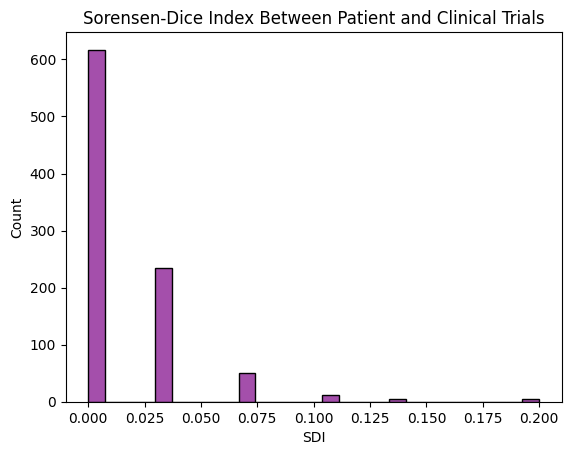

In [ ]:
# plot a histogram of the 'age' column using Seaborn
sns.histplot(data=final_df, x='SDI',color='#86148f').set_title('Sorensen-Dice Index Between Patient and Clinical Trials')
plt.show()

In [ ]:
patient_ner_df.to_csv('parsed_patient_ehr.csv', index=False)
recruiting_trials_df.to_csv('recruiting_clinical_trials.csv', index=False)
final_df.to_csv('parsed_clinical_trials.csv', index=False)

In [ ]:
 # Process the text using the nlp model
nlp = spacy.load("en_ner_bc5cdr_md")
nlp.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 1})
linker_bc5cdr = nlp.get_pipe("scispacy_linker")

In [ ]:
def get_semantic_types(cui, api_key):
    base_url = "https://uts-ws.nlm.nih.gov/rest"
    
    # Get the service ticket granting ticket (TGT)
    auth_endpoint = "https://utslogin.nlm.nih.gov/cas/v1/tickets"
    auth_data = {"apikey": api_key}
    response = requests.post(auth_endpoint, data=auth_data)
    response.raise_for_status()
    tgt = response.headers["location"]

    # Get the service ticket
    service_ticket_endpoint = f"{tgt}"
    service_ticket_data = {"service": "http://umlsks.nlm.nih.gov"}
    response = requests.post(service_ticket_endpoint, data=service_ticket_data)
    response.raise_for_status()
    service_ticket = response.text

    # Get the semantic types
    url = f"{base_url}/content/current/CUI/{cui}?ticket={service_ticket}"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    # Extract semantic type names
    semantic_types = [info["name"] for info in data["result"]["semanticTypes"]]
    return semantic_types

def process_text(text: str, api_key):
    # Process the text using the nlp models
    doc_bc5cdr = nlp(text)

    # Extract entities, semantic mapping, and UMLS codes
    results = []
    for doc, linker in [(doc_bc5cdr, linker_bc5cdr)]:
        for ent in doc.ents:
            umls_mappings = ent._.kb_ents
            if umls_mappings:
                umls_code = umls_mappings[0][0]
                umls_entity = linker.kb.cui_to_entity[umls_code]
                semantic_types = get_semantic_types(umls_code, api_key)
                results.append((ent.text, semantic_types, umls_code))

    # Extract numerical quantities (age and dosage)
    age_pattern = re.compile(r'(\d+)\s?(?:year|yr|Y)?[ \-]?old', re.IGNORECASE)
    dosage_pattern = re.compile(r'(\d+(?:\.\d+)?)\s?(mg|g|mcg|ml|l|units|unit|u|i\.?u\.?)', re.IGNORECASE)

    age_matches = age_pattern.findall(text)
    dosage_matches = dosage_pattern.findall(text)

    # Append age and dosage information to the results
    for match in age_matches:
        results.append((f"{match} years old", "Age", None))

    for match in dosage_matches:
        quantity, unit = match
        results.append((f"{quantity} {unit}", "Dosage", None))

    return results

api_key = '7eaeb202-9f78-47b2-b276-5081d0845752'

text = "A 45-year-old male patient presented with a 3-day history of fever, cough, and shortness of breath. He has a past medical history of type 2 diabetes and hypertension. \
Physical examination revealed bilateral crackles on lung auscultation. A chest X-ray showed bilateral infiltrates suggestive of pneumonia. The patient was prescribed azithromycin 500 mg once daily \
and ceftriaxone 1 g intravenously for community-acquired pneumonia, and his blood glucose was managed with metformin 1000 mg twice daily. The patient was advised to follow up in one week."

entities = process_text(text, api_key)

for entity in entities:
    print(f"Entity: {entity[0]}, Type: {entity[1]}, UMLS Code: {entity[2]}")

Entity: fever, Type: ['Sign or Symptom'], UMLS Code: C0015967
Entity: cough, Type: ['Sign or Symptom'], UMLS Code: C0010200
Entity: shortness of breath, Type: ['Sign or Symptom'], UMLS Code: C0013404
Entity: diabetes, Type: ['Disease or Syndrome'], UMLS Code: C0011847
Entity: hypertension, Type: ['Disease or Syndrome'], UMLS Code: C0020538
Entity: pneumonia, Type: ['Disease or Syndrome'], UMLS Code: C0032285
Entity: azithromycin, Type: ['Organic Chemical', 'Antibiotic'], UMLS Code: C0052796
Entity: ceftriaxone, Type: ['Organic Chemical', 'Antibiotic'], UMLS Code: C0007561
Entity: community-acquired pneumonia, Type: ['Disease or Syndrome'], UMLS Code: C0694549
Entity: glucose, Type: ['Organic Chemical', 'Pharmacologic Substance', 'Biologically Active Substance'], UMLS Code: C0017725
Entity: metformin, Type: ['Organic Chemical', 'Pharmacologic Substance'], UMLS Code: C0025598
Entity: 500 mg, Type: Dosage, UMLS Code: None
Entity: 1 g, Type: Dosage, UMLS Code: None
Entity: 1000 mg, Type: D

In [ ]:
model.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'negex',
 'abbreviation_detector',
 'scispacy_linker']

In [ ]:
person_pattern = [{'POS': 'PROPN', 'OP': '+'}, {'POS': 'PROPN', 'OP': '?'}, {'POS': 'PROPN'}]
location_pattern = [{'POS': 'PROPN'}, {'POS': 'ADP', 'OP': '?'}, {'POS': 'PROPN'}, {'POS': 'NOUN', 'OP': '?'}]
organization_pattern = [{'POS': 'PROPN'}, {'POS': 'NOUN', 'OP': '+'}]

In [ ]:
from spacy import displacy
# Load the language model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Define the lexicon
lexicon = {'cities': ['New York', 'Los Angeles', 'Chicago', ...],
           'countries': ['USA', 'Canada', 'Mexico', ...],
           'persons': ['John Smith', 'Mary Jones', 'Tom Lee', ...]}

# Define a function to perform NER using the lexicon
def lexicon_ner(text):
    doc = nlp(text)
    entities = []
    for token in doc:
        for entity_type, entity_list in lexicon.items():
            if token.text in entity_list:
                entities.append((token.text, entity_type))
                break
    return entities

# Test the function
text = "John Smith is from New York and works for IBM."
entities = lexicon_ner(text)
print(entities)

# Display the named entities using displacy
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

#for token in doc:
#    print(token.text, token.pos_, token.tag_, token.dep_, token.head.text)

[]


In [ ]:
# Load the dataset
data = [
    ("John Smith is the CEO of IBM and lives in New York City.", [
        ("John Smith", "PERSON"),
        ("IBM", "ORG"),
        ("New York City", "LOC")
    ])
]

In [ ]:
from sklearn.cluster import KMeans

# Load the English language model and add the NEL component
nlp = spacy.load('en_core_web_sm')
nel = nlp.add_pipe('entity_linker')

# Define the texts to analyze
texts = [
    "Apple is a technology company that produces iPhones and Macbooks.",
    "Microsoft is a software company that produces Windows and Office.",
    "Tesla is a car company that produces electric cars and solar panels."
]

# Analyze the texts with the NEL component and extract the named entities
entities = []
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        if ent._.kb_id is not None:
            entities.append((ent.text, ent._.kb_id))

# Cluster the entities based on their semantic mappings
mappings = {}
for entity in entities:
    kb_id = entity[1]
    if kb_id.startswith("Q"):
        concept = kb_id.split(":")[1]
        mappings.setdefault(concept, []).append(entity[0])

kmeans = KMeans(n_clusters=3)
X = [[len(mappings[concept])] for concept in mappings]
labels = kmeans.fit_predict(X)

# Print out the entity clusters
for i, concept in enumerate(mappings):
    print(f"Cluster {labels[i]}: {mappings[concept]}")

ValueError: ignored

In [14]:
def get_clinical_trials2(condition):
    """
    Creates a pandas dataframe from a query to clinicaltrials.gov

    Args:
    - condition: string representing the condition to search for

    Returns:
    - pandas dataframe with clinical trial data
    """
    # Check that condition is only 1 word else concatenate the string with a + sign
    multiword_condition = contains_multiple_words(condition)
    if multiword_condition:
        condition = "+".join(condition.split())

    url = f'https://clinicaltrials.gov/api/query/study_fields?expr={condition}&fields=NCTId,BriefTitle,Condition,OverallStatus,MinimumAge,MaximumAge,Gender,StudyPopulation,EligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv'

    # Send the API request and handle errors
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f'Request failed with status code {response.status_code}')
    
    # Create a pandas DataFrame from the response
    trials_df = pd.read_csv(url, skiprows=10)

    return trials_df

# Query clinical trials for lung cancer
trials_df = get_clinical_trials2('lung cancer')

In [15]:
trials_df

,Rank,NCTId,BriefTitle,Condition,OverallStatus,MinimumAge,MaximumAge,Gender,StudyPopulation,EligibilityCriteria
0,1,NCT03581708,Venous Thromboembolism in Advanced Lung Cancer,Lung Neoplasms|Venous Thromboembolism,Unknown status,18 Years,NaN,All,Patients diagnosed with advanced staged lung c...,Inclusion Criteria:||Age ≥ 18 years at the tim...
1,2,NCT05572944,Multidimensional Modeling for Never Smoking Lu...,Lung Cancer,Recruiting,20 Years,80 Years,All,NaN,Inclusion Criteria:||Age 50-80 years old||Firs...
2,3,NCT01130285,Validation of a Multi-gene Test for Lung Cance...,Lung Cancer,Unknown status,50 Years,90 Years,All,The study population will consist of subjects ...,Inclusion Criteria:||20 or more pack year smok...
3,4,NCT05762731,Screening for Lung Cancer in Subjects With Fam...,Lung Cancer,Recruiting,50 Years,75 Years,All,Subjects with lung cancer and to invite them t...,"Inclusion Criteria:||Age 50-75, men or women, ..."
4,5,NCT03992833,Methods of Computed Tomography Screening and M...,Lung Neoplasms|Computed Tomography|Mass Screen...,Unknown status,40 Years,74 Years,All,NaN,Inclusion Criteria:||Aged 40-74 years;|Residen...
...,...,...,...,...,...,...,...,...,...,...
995,996,NCT00832819,E7080 in Combination With Carboplatin and Pacl...,Non-small-cell Lung Cancer,Completed,20 Years,74 Years,All,NaN,Inclusion criteria:||Subjects with a histologi...
996,997,NCT02426658,Pemetrexed Disodium in Treating Patients With ...,Stage IV Non-Small Cell Lung Cancer,"Active, not recruiting",18 Years,NaN,All,NaN,Inclusion Criteria:||Patients must have histol...
997,998,NCT03195569,To Predict Efficacy by Detecting Circulating E...,Non Small Cell Lung Cancer,Unknown status,18 Years,75 Years,All,The patients with Non-squamous Non-small Cell ...,Inclusion Criteria:||Aged ≥18 years and ≤75 ye...
998,999,NCT00575393,Gold Sodium Thiomalate in Treating Patients Wi...,Lung Cancer,Completed,18 Years,120 Years,All,NaN,DISEASE CHARACTERISTICS:||Histologically confi...


In [21]:
# split eligibility criteria into inclusion and exclusion criteria
inclusion_criteria = []
exclusion_criteria = []
for criteria in trials_df['EligibilityCriteria']:
    if pd.notna(criteria):
        split_criteria = criteria.split('Exclusion Criteria:')
        if len(split_criteria) > 1:
            inclusion_criteria.append(split_criteria[0])
            exclusion_criteria.append(split_criteria[1])
        else:
            inclusion_criteria.append(split_criteria[0])
            exclusion_criteria.append('')

# create dataframes for inclusion and exclusion criteria
inclusion_df = pd.DataFrame({'NCTId': trials_df['NCTId'], 'InclusionCriteria': inclusion_criteria})
exclusion_df = pd.DataFrame({'NCTId': trials_df['NCTId'], 'ExclusionCriteria': exclusion_criteria})

# merge dataframes
merged_df = pd.merge(trials_df, inclusion_df, on='NCTId', how='left')
merged_df = pd.merge(merged_df, exclusion_df, on='NCTId', how='left')

# split inclusion and exclusion criteria into lists of criteria
merged_df['InclusionCriteria'] = merged_df['InclusionCriteria'].apply(lambda x: x.split('|') if pd.notna(x) else [])
merged_df['ExclusionCriteria'] = merged_df['ExclusionCriteria'].apply(lambda x: x.split('|') if pd.notna(x) else [])

# create dataframes for individual inclusion and exclusion criteria
inclusion_criteria_df = merged_df.explode('InclusionCriteria')
inclusion_criteria_df = inclusion_criteria_df[['NCTId', 'InclusionCriteria']]
inclusion_criteria_df = inclusion_criteria_df[inclusion_criteria_df['InclusionCriteria'] != '']

exclusion_criteria_df = merged_df.explode('ExclusionCriteria')
exclusion_criteria_df = exclusion_criteria_df[['NCTId', 'ExclusionCriteria']]
exclusion_criteria_df = exclusion_criteria_df[exclusion_criteria_df['ExclusionCriteria'] != '']

inclusion_criteria_df

,NCTId,InclusionCriteria
0,NCT03581708,Inclusion Criteria:
0,NCT03581708,Age ≥ 18 years at the time of screening.
0,NCT03581708,Eastern Cooperative Oncology Group performance...
0,NCT03581708,Written informed consent obtained from the pat...
0,NCT03581708,Histologically and cytologically documented St...
...,...,...
998,NCT00575393,"No other concurrent chemotherapy, immunotherap..."
998,NCT00575393,No concurrent prophylactic colony stimulating ...
999,NCT00005849,DISEASE CHARACTERISTICS: Histologically or cyt...
999,NCT00005849,PATIENT CHARACTERISTICS: Age: 18 and over Perf...


In [19]:
exclusion_df

,NCTId,ExclusionCriteria
0,NCT03581708,||History of another primary malignancy except...
1,NCT05572944,||Previous history of lung cancer|Another mali...
2,NCT01130285,||Lung Cancer within 3 months after the date o...
3,NCT05762731,||Non-Chinese|Mentally incompetent to give inf...
4,NCT03992833,||Pregnant woman will be excluded.
...,...,...
995,NCT00832819,
996,NCT02426658,||Patients who have previously received chemot...
997,NCT03195569,"||Central squamous cell carcinoma, and mixed g..."
998,NCT00575393,


In [29]:
# Choose a specific trial by its NCT ID
nct_id = trials_df['NCTId'][995]
trial = trials_df[trials_df['NCTId'] == nct_id]

# Split the eligibility criteria into inclusion and exclusion criteria
criteria = trial['EligibilityCriteria'].iloc[0]

# Split the eligibility criteria into inclusion and exclusion criteria
split_criteria = criteria.split('Exclusion criteria:')
inclusion_criteria = split_criteria[0].replace('Inclusion criteria:||', '').split('|')
inclusion_criteria = [criterion for criterion in inclusion_criteria if criterion != '']
if len(split_criteria) > 1:
    exclusion_criteria = split_criteria[1].replace('||', '').split('|')
    exclusion_criteria = [criterion for criterion in exclusion_criteria if criterion != '']

print("Inclusion criteria:")
for criterion in inclusion_criteria:
    print("- " + criterion)

print("\nExclusion criteria:")
for criterion in exclusion_criteria:
    print("- " + criterion)

Inclusion criteria:
- Subjects with a histologically or cytologically confirmed diagnosis of non-small cell lung cancer (NSCLC).
- Locally advanced and/or metastatic non-small cell lung cancer (NSCLC) (Stage IIIB/IV).
- Subjects with at least one measurable tumor lesion by Response Evaluation Criteria In Solid Tumors (RECIST).
- Subjects with Performance Status (PS) 0-1.
- Subjects with adequate organ function.

Exclusion criteria:
- Subjects who have ever received the following therapy for non-small cell lung cancer (NSCLC):Chemotherapy
- Biological or immunotherapies
- Surgery for primary focus
- The radiation therapy for primary focus
- Subjects with the severe complications or disease history.
- Subjects with brain metastasis accompanying clinical symptoms or requiring treatment.
- Subjects with simultaneous or metachronous cancers.
- Subjects who cannot take oral medication.
- Subjects who are using drugs that strongly inhibit or induce cytochrome P450 (CYP) 3A4.


In [30]:
inclusion_df = pd.DataFrame(inclusion_criteria, columns=['InclusionCriteria'])
exclusion_df = pd.DataFrame(exclusion_criteria, columns=['ExclusionCriteria'])
inclusion_df

,InclusionCriteria
0,Subjects with a histologically or cytologicall...
1,Locally advanced and/or metastatic non-small c...
2,Subjects with at least one measurable tumor le...
3,Subjects with Performance Status (PS) 0-1.
4,Subjects with adequate organ function.


In [31]:
exclusion_df

,ExclusionCriteria
0,Subjects who have ever received the following ...
1,Biological or immunotherapies
2,Surgery for primary focus
3,The radiation therapy for primary focus
4,Subjects with the severe complications or dise...
5,Subjects with brain metastasis accompanying cl...
6,Subjects with simultaneous or metachronous can...
7,Subjects who cannot take oral medication.
8,Subjects who are using drugs that strongly inh...


In [16]:
nlp = spacy.load("en_core_sci_sm")
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']

In [17]:
# Choose a specific trial by its NCT ID
nct_id = trials_df['NCTId'][998]
trial = trials_df[trials_df['NCTId'] == nct_id]

# Split the eligibility criteria into inclusion and exclusion criteria
criteria = trial['EligibilityCriteria'].iloc[0]

# Split the eligibility criteria into inclusion and exclusion criteria
inclusion_criteria = criteria.split('Inclusion Criteria:||')[1].split('Exclusion Criteria:||')[0].strip().replace('||', '. ').replace('|', ' ')
exclusion_criteria = criteria.split('Exclusion Criteria:||')[1].strip().strip().replace('||', '. ').replace('|', ' ')

## Split the eligibility criteria into sentences using spacy sentence tokenizer
doc = nlp(inclusion_criteria)
i_sentences = list(doc.sents)

doc = nlp(exclusion_criteria)
e_sentences = list(doc.sents)

#Create pandas dataframe for the IC/EC such that every row is a criteria
idf = pd.DataFrame({'Inclusion_Criteria': [sentence.text for sentence in i_sentences]})#, columns=['Eligibility Criteria'])
edf = pd.DataFrame({'Exclusion_Criteria': [sentence.text for sentence in e_sentences]})

idf

IndexError: ignored

In [13]:
edf

NameError: ignored